In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

from splot import esda as esdaplot

In [29]:
db = gpd.read_parquet("data/wijken_stedent.parquet")

db.dropna(subset=["sted/entropy"], inplace=True)

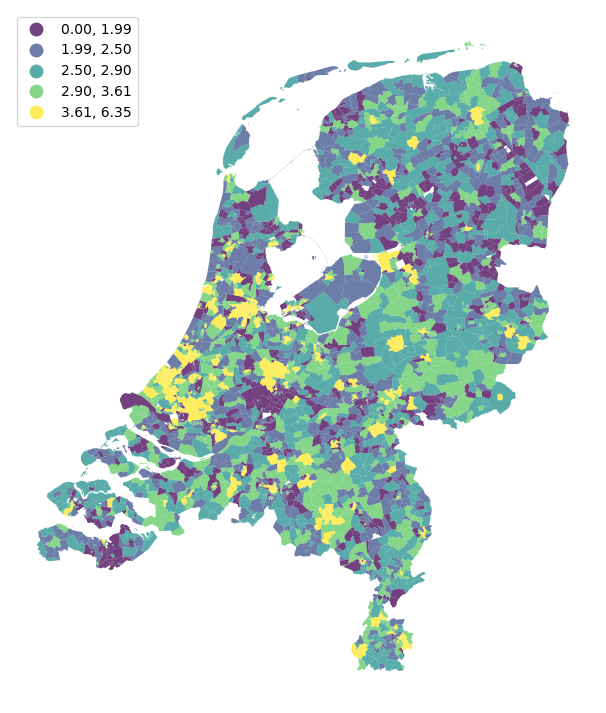

In [30]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="sted/entropy",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)

ax.set_axis_off()

In [31]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

db["w_stedent"] = weights.lag_spatial(w, db['sted/entropy'])
# db["stedent_std"] = db["sted/entropy"] - db["sted/entropy"].mean()
# db["w_stedent_std"] = weights.lag_spatial(w, db['stedent_std'])


In [32]:
# # Set up the figure and axis
# f, ax = plt.subplots(1, figsize=(6, 6))
# # Plot values
# seaborn.regplot(
#     x="stedent_std", y="w_stedent_std", data=db, ci=None
# )
# plt.show()

In [33]:
lisa = esda.moran.Moran_Local(db["sted/entropy"], w)

<Axes: ylabel='Density'>

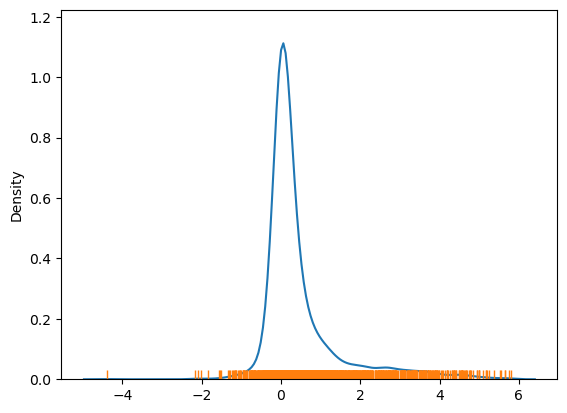

In [34]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax)

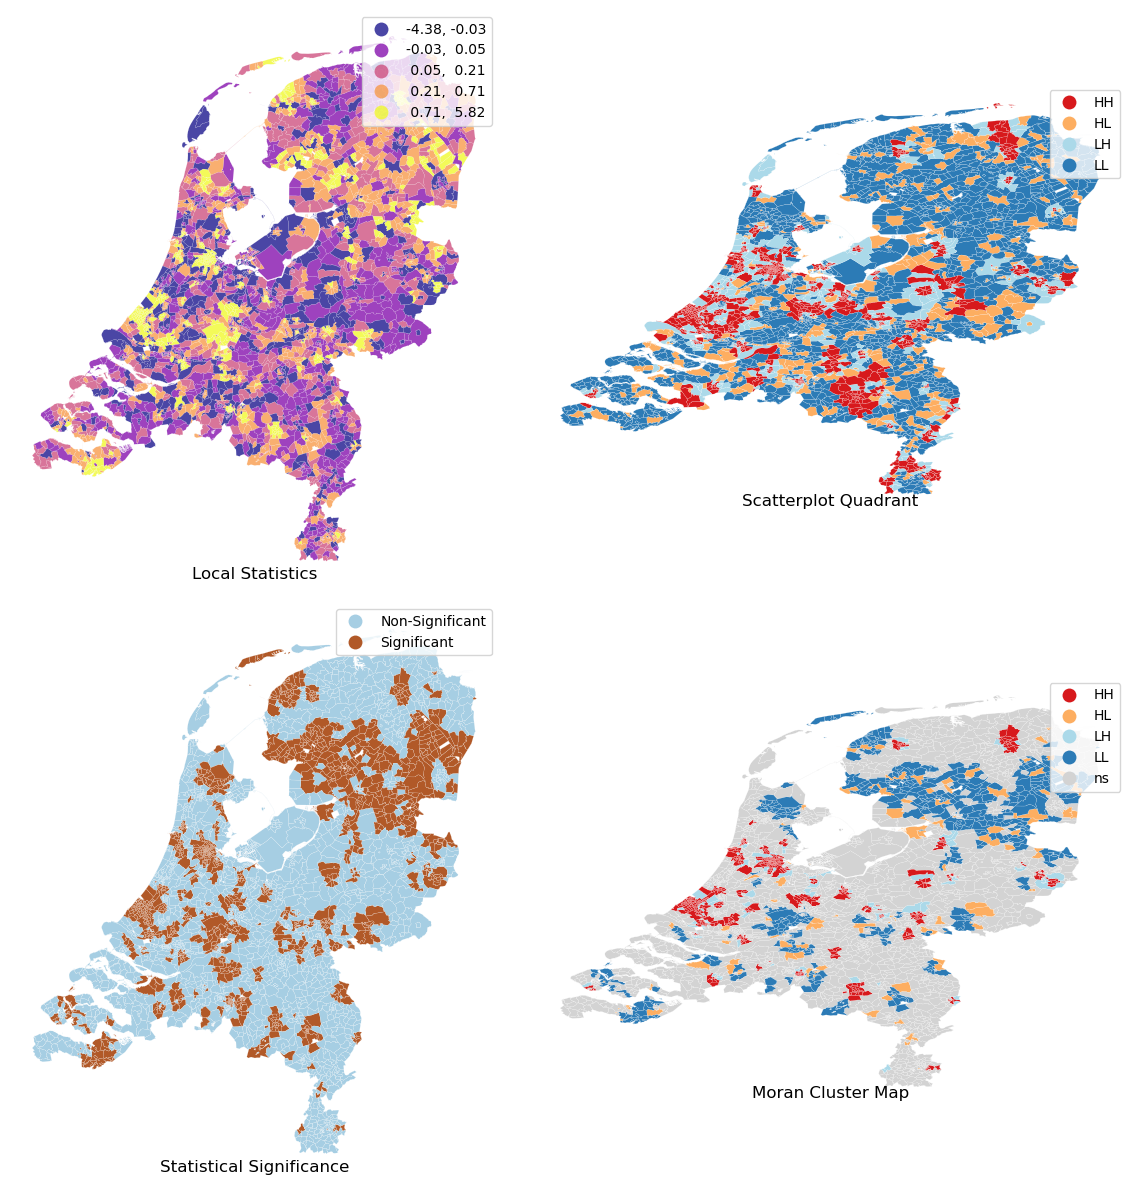

In [35]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()